Using device: cpu


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.82MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.80MB/s]


Epoch: 1, Batch: 100/938, Loss: 0.3824
Epoch: 1, Batch: 200/938, Loss: 0.3147
Epoch: 1, Batch: 300/938, Loss: 0.2275
Epoch: 1, Batch: 400/938, Loss: 0.2879
Epoch: 1, Batch: 500/938, Loss: 0.4260
Epoch: 1, Batch: 600/938, Loss: 0.1716
Epoch: 1, Batch: 700/938, Loss: 0.1109
Epoch: 1, Batch: 800/938, Loss: 0.1079
Epoch: 1, Batch: 900/938, Loss: 0.3573
Epoch: 1/10
Train Loss: 0.2792, Train Accuracy: 91.42%
Test Loss: 0.1106, Test Accuracy: 96.52%
------------------------------------------------------------
Epoch: 2, Batch: 100/938, Loss: 0.2454
Epoch: 2, Batch: 200/938, Loss: 0.1743
Epoch: 2, Batch: 300/938, Loss: 0.2009
Epoch: 2, Batch: 400/938, Loss: 0.0511
Epoch: 2, Batch: 500/938, Loss: 0.1427
Epoch: 2, Batch: 600/938, Loss: 0.1057
Epoch: 2, Batch: 700/938, Loss: 0.0701
Epoch: 2, Batch: 800/938, Loss: 0.0821
Epoch: 2, Batch: 900/938, Loss: 0.2735
Epoch: 2/10
Train Loss: 0.1293, Train Accuracy: 96.09%
Test Loss: 0.1081, Test Accuracy: 96.60%
---------------------------------------------

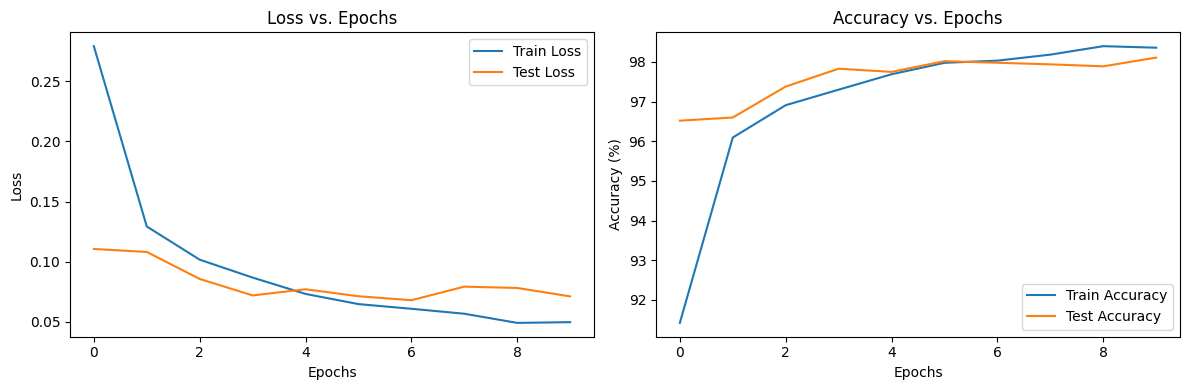

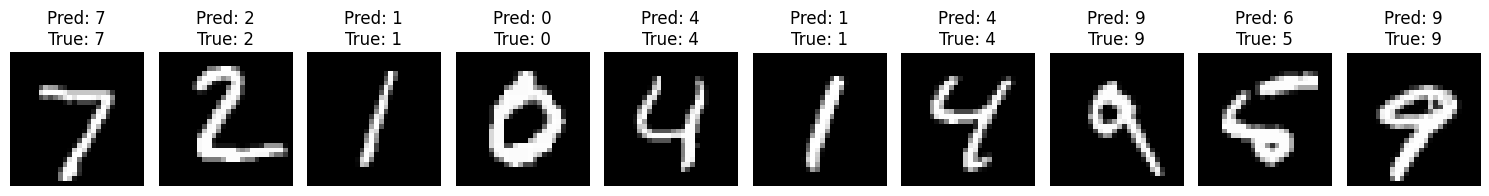

Model saved as 'mlp_mnist.pth'


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST dataset mean and std
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size1=256, hidden_size2=128, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization

    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 784)

        # First hidden layer with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Second hidden layer with ReLU activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc3(x)

        # Apply log softmax for numerical stability
        output = F.log_softmax(x, dim=1)

        return output

# Initialize the model
model = MLP().to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Print progress
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

    # Calculate epoch statistics
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    return train_loss, train_accuracy

# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)

            # Calculate loss
            test_loss += criterion(output, target).item()

            # Get predictions
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # Calculate test statistics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total

    return test_loss, test_accuracy

# Train the model
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)

    # Store statistics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print epoch statistics
    print(f'Epoch: {epoch}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    print('-' * 60)

# Plot training and test loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize some predictions
def visualize_predictions(model, device, test_loader, num_samples=10):
    model.eval()

    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Move to device
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move back to CPU for visualization
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Plot the images with predictions
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Pred: {predicted[i]}\nTrue: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, device, test_loader)

# Save the model
torch.save(model.state_dict(), 'mlp_mnist.pth')
print("Model saved as 'mlp_mnist.pth'")